# 实验说明

本实验的主要内容为：使用一种名为[DistilBERT](https://arxiv.org/abs/1910.01108)的BERT变体来自动识别人们在Twitter上发布文本的情绪状态。

实验基础代码已经在下面给出。你需要保证自己在熟悉了基础代码后，完成以下任务（使用CTRL+F，搜索‘TODO’，可以快速定位任务位置）：

1. 创建一个 `token2idx` 字典，将字符（key）映射为整数（value），用于实现字符级别的标记化操作；
2. 完善提取隐藏层 [CLS] 特征的函数；
3. 使用 Scikit-Learn 库中的不同分类模型对提取的特征进行分类，并比较不同模型的分类效果；
4. 调整模型参数，以训练出更高分类准确率的模型，探讨不同参数设置对模型训练效果的影响；
5. 分析分类错误的样本为什么会被分错，分类正确的样本为什么会被分对（选做）；
6. 生成 5 个对抗样本，尽可能让你的模型无法正确判断其情感类别，并尝试解释其中的原因（选做）。


# 实验要求
- 截止日期：$\text{2024.12.15 23:59}$
- 提交内容：源代码、HuggingFace模型地址、实验报告
- 报告要求：
    - 内容包括摘要、引言、方法、实验以及总结部分；
    - 4页左右，PDF格式。
    - 如果你在探索中有任何其它发现或想法，也请加入到报告中。

In [ ]:
# from install import *
# install_requirements()
from utils import *
setup_chapter()

# 文本情感分类

文本分类是自然语言处理中最常见的任务之一；它可用于各种应用程序，例如将客户反馈标记为不同类别。很可能你的电子邮件程序的垃圾邮件过滤器正在使用文本分类来保护你的收件箱免受大量不必要的垃圾邮件的困扰！

另一种常见的文本分类是情感分析，它旨在确定给定文本的情感。例如，像特斯拉这样的公司可能会分析Twitter上的帖子，以确定人们是否喜欢它的新车顶。

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="images/chapter02_tweet.png" id="tesla-tweet"/>

现在想象一下，你是一位数据科学家，需要构建一个系统，可以自动识别人们在Twitter上对你公司产品表达的情绪状态，比如“愤怒”或“喜悦”。在这一章中，我们将使用一种名为DistilBERT[V. Sanh et al., ["DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter"](https://arxiv.org/abs/1910.01108), (2019).]的BERT变体来解决这个任务。这个模型的主要优势在于它能够达到与BERT相媲美的性能，同时体积更小、效率更高。这使我们能够在几分钟内训练出一个分类器，如果你想训练一个更大的BERT模型，只需要简单地更改预训练模型的检查点。检查点对应于被加载到给定转换器架构中的一组权重。

这也将是我们首次接触到Hugging Face生态系统中的三个核心库：Datasets、Tokenizers和Transformers。正如所示，这些库将使我们能够快速地从原始文本转变为一个经过微调的模型，可以用于对新推文进行推断。因此，让我们按照擎天柱的精神，开始“转变并出发吧！” (擎天柱是一款儿童和年轻人心中喜爱的变形金刚系列中的机器人领导者。)

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="images/chapter02_hf-libraries.png" id="hf-libraries"/>

## 数据集

为了构建我们的情感检测器，我们将使用一篇文章中的精彩数据集[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," EMNLP, (2018), http://dx.doi.org/10.18653/v1/D18-1404.] ，该文章探讨了情绪如何在英语 Twitter 消息中被表达。与大多数情感分析数据集不同，这个数据集包含六种基本情感：愤怒、厌恶、恐惧、喜悦、悲伤和惊讶。给定一条推文，我们的任务将是训练一个模型，可以将其分类为这些情绪中的一种。

让我们用 `load_dataset()` 函数加载情`emotion`据集:

In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

如果我们查看我们的`emotions`对象：

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

我们看到它类似于一个Python字典，每个键对应不同的分割。我们可以使用通常的字典语法来访问单个分割：

In [7]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

返回一个 `Dataset` 类的实例。 `Dataset` 对象是图像处理中的核心数据结构之一，我们将在本书的过程中控制许多其特性。首先，它的行为类似于普通的 Python 数组或列表，因此我们可以查询它的长度：

In [8]:
len(train_ds)

16000

或者通过它的索引来访问单个示例：

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

在这里，我们可以看到一行数据被表示为一个字典，其中键对应于列名：

In [10]:
train_ds.column_names

['text', 'label']

值是推文和情感。这反映出数据集基于[_Apache Arrow_](https://arrow.apache.org/)，它定义了一种类型列格式，比原生Python更高效地使用内存。我们可以通过访问`Dataset`对象的`features`属性来看到底层使用的数据类型：

In [11]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


在这种情况下，`text`列的数据类型是`string`，而`label`列是一个特殊的`ClassLabel`对象，其中包含有关类别名称及其与整数的映射信息。我们还可以用切片访问几行：

In [12]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


请注意，在这种情况下，字典的值现在是列表而不是单个元素。我们还可以按名称获取整列：

In [13]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


现在我们已经看到了如何使用hf库加载和检查数据，让我们对推文内容进行一些健全性检查。

### 从 Datasets 到 DataFrames

虽然数据集提供了许多低级功能来切割和分析数据，但通常将`Dataset`对象转换为Pandas  `DataFrame`  是方便的，这样我们就可以使用高级API来进行数据可视化。为了实现转换，数据集提供了`set_format()`方法，允许我们更改数据集的输出格式。请注意，这不会改变底层数据格式（即Arrow表），如果需要，您可以随后切换到另一种格式。

In [14]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


正如你所看到的，列标题已经被保留，前几行与我们以前对数据的看法相匹配。然而，标签表示为整数，所以让我们使用标签特征的`int2str()`方法，在我们的DataFrame中创建一个新列，其中包含相应的标签名称：

In [15]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


在开始构建分类器之前，让我们仔细研究一下数据集。正如Andrej Karpathy在他著名的博客文章["A Recipe for Training Neural Networks"](https://karpathy.github.io/2019/04/25/recipe)中所指出的，与数据成为“一体”是训练优秀模型的重要步骤！

### 查看数据的分布

当你在处理文本分类问题时，检查一下各类别示例的分布是个好主意。一个类别分布不均的数据集可能需要在训练损失和评估指标方面进行不同处理，与一个平衡数据集相比。

通过 Pandas 和 Matplotlib，我们可以快速可视化类别分布，如下所示：

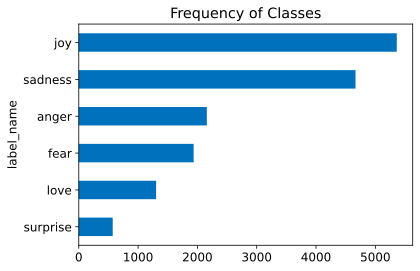

In [16]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

在这种情况下，我们可以看到数据集严重不平衡；`joy` 和 `sadness`类别经常出现，而`love` 和 `surprise` 大约是5-10倍罕见。 处理不平衡数据的几种方法，包括：

* 随机oversample少数类别。
* 随机undersample多数类别。
* 从代表少数类别的样本中收集更多数据。

为了简化这一章节，我们将使用原始的、不平衡的类别频率。如果你想了解更多关于这些采样技术的知识，我们建议您查看[Imbalanced-learn library](https://imbalanced-learn.org/stable/)。只是确保在创建训练/测试拆分之前不要应用采样方法，否则它们之间会产生很多泄漏！

现在我们已经看过类别，让我们来看看这些 tweets 本身。

### 我们的推文有多长？

Transformer 模型具有最大输入序列长度，称为“最大上下文大小”。对于使用DistilBERT的应用程序，最大上下文大小为512个标记（token），相当于几段文本。正如我们将在下一节中看到的，一个标记是文本的一个原子部分；目前，我们将一个标记视为一个单词。我们可以通过查看每种情感的推文长度的单词分布来粗略估计推文长度：

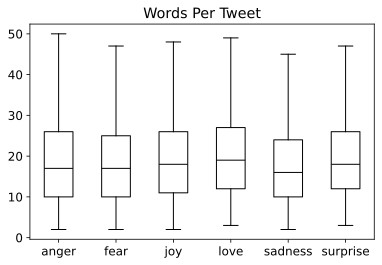

In [17]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

从情感上看，我们可以看到对于每种情绪，大多数推文大约在15个字左右，最长的推文远远在DistilBERT的最大上下文大小以下。如果文本超过模型的上下文大小，需要对其进行截断，这可能会导致性能下降，如果被截断的文本包含关键信息的话；但在这种情况下，看起来这不是一个问题。

让我们现在想一想如何将这些原始文本转换为适合 Transformers 的格式！顺便说一下，我们也要重置数据集的输出格式，因为我们不再需要DataFrame格式了。

In [18]:
emotions.reset_format()

## 从 Text 到 Tokens

Transformer模型如DistilBERT不能接收原始字符串作为输入；相反，它们假定文本已经被标记化（tokenized）并编码（encoded）为数值向量。 标记化（Tokenization）是将字符串分解为模型中使用的原子单位的步骤。 人们可以采用几种标记化策略，通常从语料库中学习单词分割的最佳方法。 在查看用于DistilBERT的标记器之前，让我们考虑两种极端情况：字符标记化和单词标记化。

### 字符标记化（Character Tokenization）

最简单的标记化方案是将每个字符单独提供给模型。在Python中，`str`对象在底层实际上是数组，这使我们能够仅用一行代码快速实现基于字符级别的标记化：

In [19]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


这是一个不错的开始，但还没有完成。我们的模型期望将每个字符转换为一个整数，有时候这个过程被称为数字化。一个简单的方法是使用一个独一无二的整数对每个唯一的标记(在这种情况下是字符)进行编码：

In [ ]:
# TODO: 将字符（key）转化为整数（value）的天然的对应python的字典dict操作，尝试写一个token2idx字典



In [20]:
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


这为我们提供了一个从词汇表中的每个字符到唯一整数的映射。现在我们可以使用 `token2idx` 将标记化文本转换为整数列表：

In [21]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


每个标记现在都映射到了一个唯一的数字标识符（因此称为`input_ids`）。最后一步是将`input_ids`转换为一个独热向量（One-hot vectors）的二维张量。One-hot vectors经常用于机器学习中对分类数据进行编码，这些数据可以是有序的或无序的。例如，假设我们想要对《变形金刚》电影中角色的名字进行编码。一种方法是将每个名字映射到一个唯一的ID，如下所示：

In [22]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


这种方法的问题在于它在名称之间创造了一个虚构的顺序，而神经网络非常擅长学习这类关系。因此，我们可以为每个类别创建一个新列，并在该类别为真时分配一个1，在其他情况下分配一个0。在 Pandas 中，可以使用 `get_dummies()` 函数来实现这一点，方法如下：

In [23]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


这个`DataFrame`的行是one-hot向量，其中有一个"hot"条目为1，其他地方都是0。添加两个one-hot编码的结果很容易解释：两个"hot"条目表示相应的标记出现。

下面我们可以通过将`input_ids`转换为tensor（张量并）应用`one_hot()`函数来在PyTorch中创建one-hot编码，如下所示：

In [24]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

对于这38个输入标识符，我们现在有一个20维的独热向量，因为我们的词汇表包含20个独特字符。

> 警告：在`one_hot()`函数中始终设置`num_classes`非常重要，否则one-hot向量可能会比词汇表的长度短（需要手动用零填充）。

通过检查第一个向量，我们可以验证在由`input_ids[0]`指示的位置上出现了1:

In [25]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


从我们简单的例子中，我们可以看到字符级的标记化忽略了文本中的任何结构，将整个字符串视为字符流。虽然这有助于处理拼写错误和罕见单词，但主要缺点是语言结构如单词需要从数据中学习。这需要大量的计算、内存和数据。因此，字符标记化在实践中很少被使用。相反，在标记化步骤中会保留文本的某些结构。单词标记化是实现这一点的一种直接方法，让我们看看它是如何工作的。

### 单词表计划（Word Tokenization）

相较于将文本分割成字符，我们可以将其分割成单词，并将每个单词映射到一个整数。从一开始就使用单词使模型能够跳过从字符中学习单词的步骤，从而减少训练过程的复杂性。

一种简单的词汇标记器类使用空格来对文本进行标记(针对英文文本)。我们可以通过直接在原始文本上应用Python的`split()`函数来实现这一点（就像我们用来测量推文长度的方式一样）。

In [26]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


从这里开始，我们可以采取与字符标记器相同的步骤，将每个单词映射到一个ID。但是，我们已经可以看到这种标记方案可能存在一个问题：标点符号没有被考虑在内，因此“NLP。”被视为一个标记。考虑到单词可能包括词形变化、时态变化或拼写错误，词汇量很容易增长到数百万以上！

> 请注意：有些词汇分词器会有针对标点符号的额外规则。为了将单词归一化为其词干（例如“great”、“greater”和“greatest”都变成“great”），也可以应用词干提取或词形还原，尽管会损失文本中的一些信息。

拥有庞大的词汇量是一个问题，因为需要神经网络具有巨大数量的参数。为了说明这一点，假设我们有100万个独特的单词，并希望将这100万维的输入向量压缩到神经网络的第一层中的1千维向量。这是大多数自然语言处理架构中的标准步骤，这个第一层的权重矩阵将包含100万×1千 = 10亿个权重。这已经可以与最大的GPT-2模型相媲美，其总参数约为15亿！

自然地，我们希望避免在模型参数上浪费，因为模型训练是昂贵的，而较大的模型更难维护。一种常见的方法是通过考虑语料库中最常见的10万个单词来限制词汇量，并且舍弃稀有单词。不在词汇表中的单词被视为`UNK`，并映射到共享的`UNK`标记。这意味着我们在词汇标记化过程中丢失了一些潜在重要的信息，因为模型对与`UNK`相关的单词没有信息。

是否有一种在字级和词级标记之间取得平衡，可以保留所有输入信息和部分输入结构？有：子词标记化（subword tokenization）。

### 子词标记化（Subword Tokenization）

基于子词标记化的基本思想是结合字符和单词标记化的最佳方面。一方面，我们希望将罕见单词拆分成较小的单元，以使模型能够处理复杂单词和拼写错误。另一方面，我们希望将频繁出现的单词保持为独特实体，这样我们可以保持输入长度在可管理的大小范围内。子词标记化（以及单词标记化）的主要区别特征在于其是通过混合统计规则和算法从预训练语料库中学习的。

在自然语言处理中常用的有几种子词标记化算法，但让我们从WordPiece算法[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] 开始，这是BERT和DistilBERT标记器使用的算法。理解WordPiece工作原理最简单的方法是看它的实际运行过程。Transformers提供了一个方便的 `AutoTokenizer`类，允许您快速加载与预训练模型相关联的标记器 - 我们只需调用其`from_pretrained()`方法，提供Hub上模型的ID或本地文件路径即可。让我们开始加载DistilBERT的标记器：

In [27]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, force_download=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/homebrew/Caskroom/miniforge/base/envs/langchain/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

AutoTokenizer 类属于一个更大的["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto)，其工作是根据检查点名称自动检索模型的配置、预训练权重或词汇表。这使您能够快速在模型之间切换，但如果您希望手动加载特定类，也是可以的。例如，我们可以这样加载 DistilBERT tokenizer：

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> 请注意：当您第一次运行AutoTokenizer.from_pretrained()方法时，您会看到一个进度条，显示从Hugging Face Hub加载的预训练的令牌化器的哪些参数。当您第二次运行代码时，它将从缓存中加载令牌化器，通常位于~/.cache/huggingface/。

让我们看看这个分词器是如何工作的，让它吃掉我们这个简单的“将文本标记化是自然语言处理的核心任务。”示例文本：

In [28]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

就像我们在字符标记化中看到的那样，我们可以看到单词已经被映射到`input_ids`字段中的唯一整数。我们将在下一节讨论`attention_mask`字段的作用。现在我们有了`input_ids`，我们可以通过使用标记器的`convert_ids_to_tokens()`方法将它们转换回标记。

In [29]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


我们可以在这里观察到三件事情。首先，一些特殊的`[CLS]` 和 `[SEP]`标记已经被添加到序列的开始和结尾。这些标记因模型而异，但它们的主要作用是表示序列的开始和结束。其次，这些标记已经被转换为小写，这是这个特定检查点的一个特征。最后，我们可以看到"tokenizing"和"NLP"已经被拆分成两个标记，这是有道理的，因为它们不是常见词。在`##izing`和`##p`中的`##`前缀表示前面的字符串不是空格；当您将标记转换回字符串时，带有这个前缀的任何标记应与前一个标记合并。`AutoTokenizer`类有一个 `convert_tokens_to_string()`方法来执行这个操作，所以让我们把它应用到我们的标记上：

In [30]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


`AutoTokenizer`类还具有几个属性，可以提供有关分词器的信息。例如，我们可以检查词汇表大小：

In [31]:
tokenizer.vocab_size

30522

和相应模型的最大上下文大小：

In [32]:
tokenizer.model_max_length

512

另一个有趣的属性是了解模型在前向传递中期望的字段名称：

In [33]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

现在我们对单个字符串的标记化过程有了基本了解，让我们看看如何对整个数据集进行标记化！

> 警告：在使用预训练模型时，确保要使用与模型训练时相同的tokenizer是非常重要的。从模型的角度看，更换标记器就像是洗牌词汇一样。如果你周围的人开始将“house”这样的随机词语互换成“猫”，你也会很难理解发生了什么！

### Tokenizing 整个 Datasets

为了对整个语料库进行标记化，我们将使用`DatasetDict`对象的`map()`方法。在本书中我们会经常遇到这个方法，因为它提供了一种方便的方式来对数据集中的每个元素应用处理函数。正如我们将很快看到的那样，map()方法也可以用来创建新的行和列。

要开始，我们需要的第一件事是一个处理函数来对我们的示例进行标记化：

In [34]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

这个函数将分词器应用到一批示例上；`padding=True`将用零填充示例，使它们的大小与批中最长的示例相同，`truncation=True`将截断示例以符合模型的最大上下文大小。要查看`tokenize()`的运行情况，让我们传递训练集中两个示例组成的一批。

In [35]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


这里我们可以看到填充的结果：`input_ids`的第一个元素比第二个元素短，因此在该元素中添加了零，以使它们具有相同的长度。这些零在词汇表中有一个相应的 `[PAD]`标记，并且特殊标记集还包括我们之前遇到的`[CLS]` 和 `[SEP]`标记。

In [36]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


另外，请注意，除了将编码后的推文返回为`input_ids`之外，分词器还会返回一个`attention_mask`数组列表。这是因为我们不希望模型被额外的填充令牌混淆：注意力掩码使模型能忽略输入中的填充部分。`attention_mask`提供了一个关于输入ID和注意力掩码如何填充的视觉解释。

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="images/chapter02_attention-mask.png" id="attention-mask"/> 

一旦我们定义了一个处理函数，我们就可以用一行代码在语料库中的所有分割中应用它：

In [37]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

默认情况下，`map()`方法会对语料库中的每个示例进行单独操作，因此设置 `batched=True` 将对推文进行分批编码。由于我们设置了 `batch_size=None`，我们的 `tokenize()` 函数将在整个数据集上作为单个批次应用。这确保了输入张量和注意力掩码在全局上具有相同的形状，我们可以看到这一操作已将新的 `input_ids` 和 `attention_mask` 列添加到数据集中：

In [38]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: 在后面的章节中，我们将看到如何使用数据整理器来动态填充每个批次中的张量。在下一节中，全局填充将会派上用场，我们将从整个语料库中提取特征矩阵。

## 训练文本分类器

DistilBERT等模型经过预训练，可以预测文本序列中的屏蔽单词。然而，我们不能直接将这些语言模型用于文本分类；我们需要稍微修改它们。为了理解需要哪些修改，让我们看看基于编码器的模型（如DistilBERT）的架构。

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="images/chapter02_encoder-classifier.png" id="encoder-classifier"/>

首先，文本被标记化并表示为称为标记编码的独热向量。令牌器词汇表的大小确定了标记编码的维度，通常包含20k至200k个唯一标记。接下来，这些标记编码被转换为标记嵌入，该嵌入是存在于较低维度空间中的向量。然后，将标记嵌入传递通过编码器块层以产生每个输入标记的隐藏状态。对于语言建模的预训练目标，每个隐藏状态被送入一个层，该层预测被掩盖的输入标记。对于分类任务，我们用分类层替换语言建模层。

> note: 实际上，PyTorch在实践中跳过了为令牌编码创建独热向量的步骤，因为将矩阵与独热向量相乘与从矩阵中选择一列相同。通过从矩阵中获取令牌ID对应的列，可以直接完成这一步骤。当我们使用nn.Embedding类时，我们将会看到这一点。

我们有两种选择来训练我们的 Twitter 数据集上的这种模型：

*  Feature Extractors（特征提取）：我们将隐藏状态用作特征，只是在其上训练一个分类器，而不修改预训练模型。
*  Fine-tune(微调)：我们端对端地训练整个模型，这也会更新预训练模型的参数。

在接下来的章节中，我们将探讨 DistilBERT 的这两种选择，并检查它们的权衡。

### Transformers作为特征抽取器

使用transformer作为特征提取器是相当简单的。我们在训练过程中冻结主体的权重，并使用隐藏状态作为分类器的特征。这种方法的优势在于我们可以很快地训练一个小型或浅层模型。这样的模型可以是一个神经分类层，也可以是一个不依赖梯度的方法，比如随机森林。如果GPU不可用，这种方法尤其方便，因为隐藏状态只需要预先计算一次。

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="images/chapter02_encoder-feature-based.png" id="encoder-features"/>

#### 使用预训练模型

我们将使用另一个方便的自动类叫做Transformers的`AutoModel`。与`AutoTokenizer`类似，`AutoModel`具有`from_pretrained()`方法来加载预训练模型的权重。让我们使用这个方法加载DistilBERT 的 checkpoint(检查点)：

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

这里我们使用PyTorch来检查GPU是否可用，然后将PyTorch `nn.Module.to()` 方法链接到模型加载器。这确保了如果有GPU，模型将在GPU上运行。如果没有，模型将在CPU上运行，这可能会慢得多。

`AutoModel`类将token encodings转换为embeddings（嵌入），并通过编码器将其馈送以返回隐藏状态。让我们看看如何从我们的语料库中提取这些状态。

#### 抽取最后一个的隐藏层状态

为了热身，让我们获取单个字符串的最后隐藏状态。我们需要做的第一件事是对字符串进行编码，并将标记转换为PyTorch张量。这可以通过向分词器提供`return_tensors="pt"`参数来完成。

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


正如我们所看到的，生成的张量形状为`[batch_size, n_tokens]`。现在我们已经将编码作为张量，最后一步是将它们放置在与模型相同的设备上，并按照以下方式传递输入：

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


这里我们使用了`torch.no_grad()`上下文管理器来禁用梯度的自动计算。这在推理过程中非常有用，因为它减少了计算的内存占用。根据模型的配置，输出可以包含多个对象，例如隐藏状态、损失或注意力，这些对象以类似于Python中的`namedtuple`的方式排列。在我们的示例中，模型输出是`BaseModelOutput`的一个实例，我们可以通过名称简单地访问它的属性。当前模型仅返回一个属性，即最后的隐藏状态，所以让我们来检查其形状：

In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

查看隐藏状态张量，我们发现它的形状为`[batch_size, n_tokens, hidden_dim]`。换句话说，对于每个输入令牌，都返回一个768维向量。对于分类任务，通常的做法是只使用与`[CLS]`令牌关联的隐藏状态作为输入特征。由于这个令牌出现在每个序列的开头，我们可以通过简单地索引到`outputs.last_hidden_state`来提取它，如下所示：

In [1]:
outputs.last_hidden_state[:,0].size()

NameError: name 'outputs' is not defined

现在我们知道如何获取单个字符串的最后一个隐藏状态，让我们为整个数据集做同样的事情，创建一个新的`hidden_state`列，存储所有这些向量。就像我们对分词器所做的那样，我们将使用`DatasetDict`的`map()` 方法一次性提取所有隐藏状态。我们需要做的第一件事是将先前的步骤封装在一个处理函数中：

In [ ]:
# TODO: 试着补全抽取隐藏层[CLS]特征的函数
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    pass
    # Extract last hidden states
    pass
    # Return vector for [CLS] token
    pass

这个函数和我们先前的逻辑唯一的区别就是最后一步，我们将最终隐藏状态放回 CPU 上作为 NumPy 数组。当我们使用批处理输入时，`map()` 方法要求处理函数返回 Python 或 NumPy 对象。

由于我们的模型期望张量作为输入，下一步要做的是将 `input_ids` 和 `attention_mask` 列转换为 "torch" 格式，如下所示：

In [ ]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

我们接着可以一次性提取所有分割中的隐藏状态：

In [ ]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

请注意，这种情况下我们并没有设置`batch_size=None`，所以默认的`batch_size=1000`被使用了。正如预期的那样，应用`extract_hidden_states()`函数已经在我们的数据集中添加了一个新的`hidden_state`列。

In [ ]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

现在我们有与每条推文关联的隐藏层状态，下一步是对其进行分类器训练。为了做到这一点，我们需要一个特征矩阵 - 让我们来看一下。

#### 创建特征矩阵

预处理后的数据集现在包含了我们训练分类器所需的所有信息。我们将使用隐藏状态作为输入特征，标签作为目标。我们可以按照以下方式轻松地创建对应的数组，使用众所周知的Scikit-Learn格式：

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

在我们对隐藏层状态进行模型训练之前，最好先进行一次健全性检查，以确保它们提供了我们想要分类的情绪的有用表示。在下一个部分中，我们将看到可视化特征为实现这一目标提供了一种快速方法。

#### 可视化训练集

由于在768维空间中可视化隐藏状态有点棘手，我们将使用强大的UMAP算法将向量投影到2D上。由于UMAP在特征被缩放到`[0,1]`区间时效果最好，我们将首先应用`MinMaxScaler`，然后使用`umap-learn`库中的UMAP实现来减少隐藏状态：

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.358075,6.140816,0
1,-3.134567,5.329446,0
2,5.152230,2.732643,3
3,-2.519018,3.067250,2
4,-3.364520,3.356613,3


结果是一个具有相同数量的训练样本的数组，但只有2个特征，而不是我们最初的768个！让我们进一步研究压缩数据，并分别绘制每个类别的点密度：

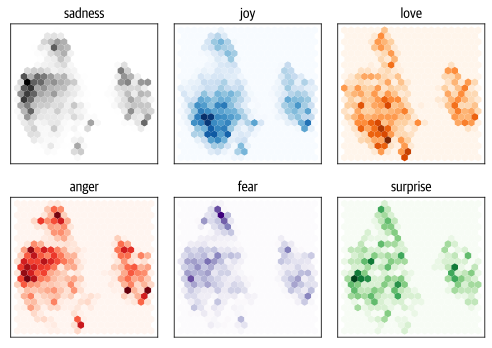

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


>请注意：这些只是在一个低维空间中的投射。 一些类别重叠并不意味着它们在原始空间中就无法分离。 相反，如果它们在投射空间中是可分离的，那么它们在原始空间中也将是可分离的。

从这个图中，我们可以看到一些明显的模式：如`sadness`, `anger`, 和 `fear`等负面情绪都占据着相似的区域，只是分布略有不同。另一方面，`joy` 和 `love`则与负面情绪明显分开，同时也共享着一个相似的空间。最后，`surprise`则散落在各个地方。尽管我们可能希望能够有一些分离，但这绝对不是一定的，因为模型并没有经过训练来区分这些情绪。它只是通过猜测文本中的掩盖单词而隐式学习这些情绪。

现在我们已经对数据集的特征有了一些了解，让我们最终在上面训练一个模型吧！

#### 训练一个简单的分类器


我们发现，尽管有些情绪之间的隐状态有所不同，但对于其中几种情绪来说并没有明显的界限。让我们使用这些隐藏状态来训练一个分类模型，使用[Scikit-Learn](https://scikit-learn.org/stable/)。下面我们以逻辑回归分类模型进行举例，训练这样一个简单模型很快速，而且不需要GPU。

In [ ]:
#TODO：，请同学尝试下Scikit-Learn中的其他分类模型，对比不同模型的分类效果，并分析。

In [ ]:
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)

/home/lewis/miniconda3/envs/book/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
lr_clf.score(X_valid, y_valid)

0.6085

看准确率可能会觉得我们的模型比随机好一点点，但因为我们在处理一个不平衡的多类别数据集，实际上效果要好得多。我们可以通过将其与简单基准进行比较来检查我们的模型是否有效。在Scikit-Learn中，有一个`DummyClassifier`，可以用来使用简单的启发式构建分类器，比如总是选择最常见的类别或总是随机选择一个类别。在这种情况下，效果最好的启发式是总是选择最频繁的类别，这样可以获得约35%的准确率：

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

所以，我们带有DistilBERT embedding 的简单分类器明显比我们的基线更好。我们可以通过查看分类器的混淆矩阵进一步调查模型的性能，混淆矩阵告诉我们真实标签和预测标签之间的关系：

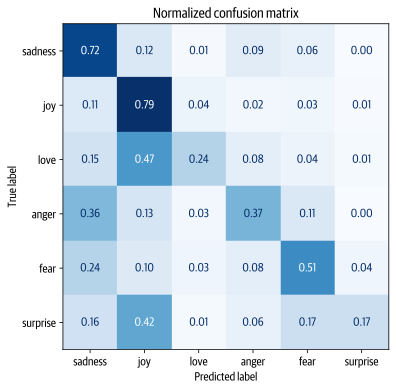

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(y_preds, y_valid, labels)

我们可以看到，`anger` 和 `fear`经常会被误解为`sadness`，这与我们在可视化嵌入时所做的观察相符。而`love` 和 `surprise`也经常被误解为快乐。

在接下来的部分中，我们将探讨微调方法，这会带来更优越的分类性能。然而，重要的是要注意，这样做需要更多的计算资源，比如GPU，在你的组织中可能没有。在这种情况下，基于特征的方法可能是传统机器学习和深度学习之间的一个好折中方案。

### 微调（Fine-Tuning） Transformers

现在让我们来探讨如何逐步端到端的优化一个transformer。通过微调的方法，我们不使用隐藏状态作为固定特征，而是训练它们。这需要分类头是可微分的，这就是为什么这种方法通常使用神经网络进行分类的原因。

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="images/chapter02_encoder-fine-tuning.png" id="encoder-tuning"/>

训练用来作为分类模型输入的隐藏状态将有助于避免使用可能不适合分类任务的数据的问题。相反，在训练过程中，初始隐藏状态会适应以减少模型损失，从而提高其性能。

我们将使用 Transformers的`Trainer` API来简化训练循环。让我们看看我们需要设置一个的所需材料！

#### 加载预训练模型

首先我们需要的是一个预训练的DistilBERT模型，就像我们在基于特征的方法中使用的那个一样。唯一的细微修改是我们使用`AutoModelForSequenceClassification`模型而不是`AutoModel`。区别在于`AutoModelForSequenceClassification`模型在预训练模型输出的顶部有一个分类头，可以很容易地与基本模型一起训练。我们只需要指定模型需要预测多少个标签（在我们的情况中是六个），因为这会决定分类头输出的数量：

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

您将看到警告，说明模型的某些部分是随机初始化的。这是正常的，因为分类头部还没有被训练过。接下来的步骤是定义我们将用来在微调过程中评估模型性能的指标。

#### 定义性能指标（Metrics）

为了在训练过程中监控性能指标，我们需要为 `Trainer` 定义一个 `compute_metrics()` 函数。该函数接收一个 `EvalPrediction 对象`（一个具有 `predictions` 和 `label_ids` 属性的命名元组），并需要返回一个字典，将每个指标的名称映射到其值。对于我们的应用程序，我们将计算模型的 $F_1$-score 和 accuracy ，方法如下：

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

有了数据集和指标准备就绪，我们在定义`Trainer`类之前只需要处理两件最后的事情：

1. 登录到我们在Hugging Face Hub上的帐户。这将允许我们将我们微调过的模型推送到Hub上的帐户，并与社区分享。

2. 为训练运行定义所有超参数。

我们将在下一节中完成这些步骤。

#### 训练模型

定义训练参数，我们使用`TrainingArguments`类。这个类存储了大量信息，并且让你对训练和评估有着精细的控制。要指定的最重要参数是`output_dir`，这是训练过程中所有工件的存储位置。这里有一个`TrainingArguments`的全貌示例：

In [ ]:
from transformers import Trainer, TrainingArguments

#TODO: 请大家试着调整模型参数，得到分类效果更优的模型，并试着探究不同参数对模型训练效果的影响。

batch_size = 8
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=1,
                                  learning_rate=1e-3,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

在这里我们还设置了批处理大小、学习率和训练周期的数量，并指定在训练结束时加载最佳模型。有了这个最后的步骤，我们可以使用`Trainer`实例化并对模型进行微调：

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.840900,0.327445,0.896500,0.892285
2,0.255000,0.220472,0.922500,0.922550


从日志中我们可以看到，我们的模型在验证集上的$F_1$-score约为92％ - 这是比基于特征的方法明显的改进！

我们可以通过计算混淆矩阵来更详细地查看训练指标。要可视化混淆矩阵，首先需要获得验证集的预测值。`Trainer`类的`predict()`方法返回一些有用的对象，我们可以用于评估。

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

`predict()`方法的输出是一个`PredictionOutput`对象，包含了`predictions`和`label_ids`的数组，以及我们传递给训练器的指标。例如，验证集上的指标可以通过以下方式访问：

In [ ]:
preds_output.metrics

{'test_loss': 0.22047173976898193,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225500751072866,
 'test_runtime': 1.6357,
 'test_samples_per_second': 1222.725,
 'test_steps_per_second': 19.564}

它还包含每个类别的原始预测。我们可以使用 `np.argmax()` 贪婪地解码预测。这将产生预测的标签，并与 Scikit-Learn 模型在基于特征的方法中返回的标签具有相同的格式：

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

根据预测，我们可以再次绘制混淆矩阵：

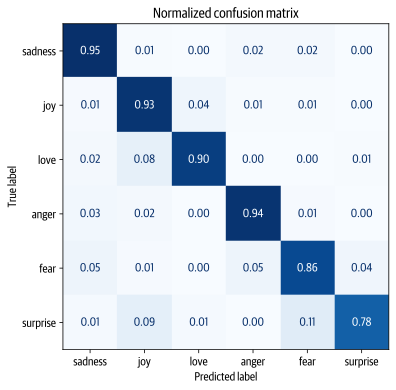

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

这个矩阵更接近理想的对角混淆矩阵。`love` 的类别仍然经常被误认为是`joy`，这似乎很自然。`surprise`也经常被误认为是`joy`，或与`fear`混淆。总的来说，模型的性能似乎相当不错，但在我们结束之前，让我们深入了解一下我们的模型可能会犯的错误类型。

### 错误分析

在继续之前，我们应该进一步调查我们模型的预测。 一个简单而有效的技术是通过模型损失对验证样本进行排序。 在前向传递标签时，损失会自动计算并返回。 这里是一个返回损失和预测标签的函数：

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

再次使用`map()`方法，我们可以将这个函数应用到所有样本上，得到损失。

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

最后，我们创建一个包含文本、损失值以及预测/真实标签的`DataFrame`：

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
#TODO：我们现在可以很容易地按照`emotions_encoded`的损失值进行升序或降序排序。请大家分析，分类错误的样本为什么会被分错，分类正确的样本为什么会被分对？

让我们首先看一下损失最大的数据样本：

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.704531
1963,i called myself pro life and voted for perry w...,joy,sadness,5.484461
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.434768
882,i feel badly about reneging on my commitment t...,love,sadness,5.257482
1950,i as representative of everything thats wrong ...,surprise,sadness,4.827708
1509,i guess this is a memoir so it feels like that...,joy,fear,4.713047
1274,i am going to several holiday parties and i ca...,joy,sadness,4.704955
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.656096
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.593202
1111,im lazy my characters fall into categories of ...,joy,fear,4.311287


分析：分类错误的样本为什么会被分错？

我们再看看损失最小的数据样本：

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017331
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017392
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017400
392,i remember feeling disheartened one day when w...,sadness,sadness,0.017461
1310,i feel like an ungrateful asshole,sadness,sadness,0.017485
189,i leave the meeting feeling more than a little...,sadness,sadness,0.017670
1120,i am feeling a little disheartened,sadness,sadness,0.017685
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.017888
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017899
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017913


分析：分类正确的样本为什么会被分对？

### 保存和分享模型

您可以使用以下辅助函数登录到Huggingface。

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

这将显示一个小部件，您可以在其中输入用户名和密码，或者具有写权限的访问令牌。您可以在[Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens)中找到有关如何创建访问令牌的详细信息。如果您在终端工作，可以通过运行以下命令登录：

```bash
$ huggingface-cli login
```

NLP 社区受益良多于共享预训练和微调模型，每个人都可以通过 Hugging Face Hub 与他人共享自己的模型。任何社区生成的模型都可以像我们下载 DistilBERT 模型一样从 Hub 下载。使用 `Trainer` API，保存和共享模型变得简单起来。

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/lewtun/distilbert-base-uncased-finetuned-emotion/commit/352c4147e4754f73a0b41f7b175f4a907270c9c9'

我们还可以使用微调过的模型来对新推文进行预测。由于我们已经将模型推送到了 Hub，现在我们可以使用 `pipeline()` 函数来使用它，就像在<>中所做的那样。首先，让我们加载 pipeline:

In [ ]:
from transformers import pipeline

# Change `XXX` to your Hub username
model_id = "XXX/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

使用以下pipeline可以直接对任意推文进行情感分类：

TODO：构造5条对抗样本，尽可能的让你的模型无法正确的判断其情感类别，并试着解释原因？

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

最后，我们可以在条形图中绘制每个类别的概率。显然，模型估计最有可能的类别是喜悦，这似乎是合理的，考虑到推文内容。

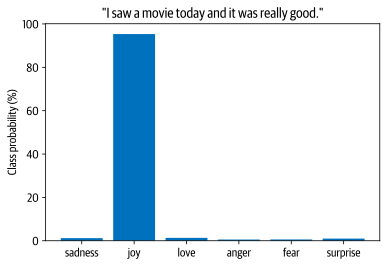

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()